<a href="https://colab.research.google.com/github/qxzss303/Squirrel-Activity-in-NY/blob/main/Squirrel_Activity_in_New_York_City.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install matplotlib
import matplotlib.pyplot as plt

!pip install pandas
import pandas as pd

!pip install numpy
import numpy as np

import statsmodels.stats.multicomp as mc

!pip install scikit-learn
import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn import datasets, model_selection, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import *
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading dataset into colab from GitHub
url = 'https://raw.githubusercontent.com/qxzss303/Squirrel-Activity-in-NY/refs/heads/main/2018_Central_Park_Squirrel_Census_-_Squirrel_Data_20250721.csv'
squirrel_df = pd.read_csv(url)

#Display frist five rows of dataset
squirrel_df.head()


,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,Kuks,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from,Other Interactions,Lat/Long
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,10142018,3,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9561344937861 40.7940823884086)
1,-73.968857,40.783783,21B-AM-1019-04,21B,AM,10192018,4,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9688574691102 40.7837825208444)
2,-73.974281,40.775534,11B-PM-1014-08,11B,PM,10142018,8,NaN,Gray,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.97428114848522 40.775533619083)
3,-73.959641,40.790313,32E-PM-1017-14,32E,PM,10172018,14,Adult,Gray,NaN,...,False,False,False,False,False,False,False,True,NaN,POINT (-73.9596413903948 40.7903128889029)
4,-73.970268,40.776213,13E-AM-1017-05,13E,AM,10172018,5,Adult,Gray,Cinnamon,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9702676472613 40.7762126854894)


In [3]:
#Print infromation of DataFrame
squirrel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3023 entries, 0 to 3022
Data columns (total 31 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   X                                           3023 non-null   float64
 1   Y                                           3023 non-null   float64
 2   Unique Squirrel ID                          3023 non-null   object 
 3   Hectare                                     3023 non-null   object 
 4   Shift                                       3023 non-null   object 
 5   Date                                        3023 non-null   int64  
 6   Hectare Squirrel Number                     3023 non-null   int64  
 7   Age                                         2902 non-null   object 
 8   Primary Fur Color                           2968 non-null   object 
 9   Highlight Fur Color                         1937 non-null   object 
 10  Combination 



---


# **Initial Research Question:**

Do squirrels have different tail movement depending on location?


---



In [4]:
#Check for null entry in 'Location'
squirrel_df['Location'].unique()

array([nan, 'Above Ground', 'Ground Plane'], dtype=object)

In [5]:
#Check for null entry in 'Tail flags'
squirrel_df['Tail flags'].unique()

array([False,  True])

In [6]:
#Copy original Dataframe
squirrel_location_filled_df = squirrel_df.copy()

#Replace all null value in 'Location' to 'Unknown location'
squirrel_location_filled_df['Location'].fillna('Unknown location', inplace = True)

In [7]:
#Double check if nan were dropped in the 'Location' column
squirrel_location_filled_df['Location'].unique()

array(['Unknown location', 'Above Ground', 'Ground Plane'], dtype=object)

In [8]:
#Frequency count of each category in 'Location'
squirrel_location_filled_df['Location'].value_counts()

,count
Location,
Ground Plane,2116
Above Ground,843
Unknown location,64


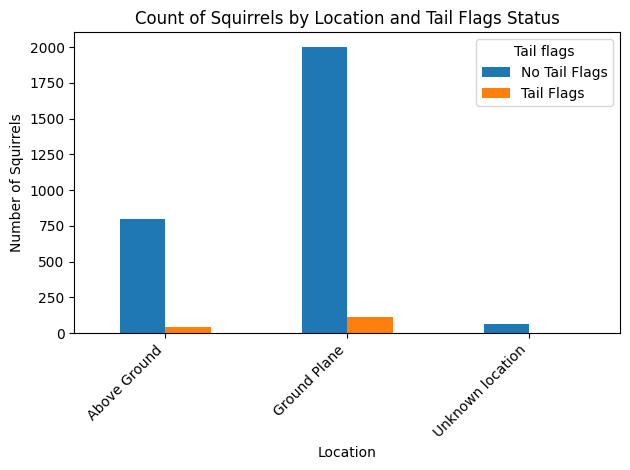

In [9]:
#Format the output as True or False
squirrel_location_filled_df['Tail flags'] = squirrel_location_filled_df['Tail flags'].astype(str).str.lower().map({'true':True, 'false':False})

#Fill any remaining NaNs in 'Tail flags' as False
squirrel_location_filled_df['Tail flags'].fillna(False, inplace=True)

#Group 'Tail flags' results by 'Location' and unstack the output for better visualization
tail_flags_by_location = squirrel_location_filled_df.groupby('Location')['Tail flags'].value_counts().unstack(fill_value=0)
tail_flags_by_location.rename(columns = {False:'No Tail Flags', True:'Tail Flags'}, inplace=True)

#Bar plot
tail_flags_by_location.plot(kind='bar', ax=plt.gca())
plt.title('Count of Squirrels by Location and Tail Flags Status')
plt.xlabel('Location')
plt.ylabel('Number of Squirrels')
plt.xticks(rotation = 45, ha='right')
plt.tight_layout()
plt.show()

It seems that number of tail flags on ground is higher than those are above ground; however, this is a misintrepetation since there are more data for squirrels on ground than above ground. This plot is misleading.

I will run a plot to show proportions of tail movement vs location.

Tail flags        No Tail Flags  Tail Flags  Total
Location                                          
Above Ground                801          42    843
Ground Plane               2003         113   2116
Unknown location             64           0     64


Tail flags        No Tail Flags  Tail Flags  Total
Location                                          
Above Ground          95.017794    4.982206  100.0
Ground Plane          94.659735    5.340265  100.0
Unknown location     100.000000    0.000000  100.0


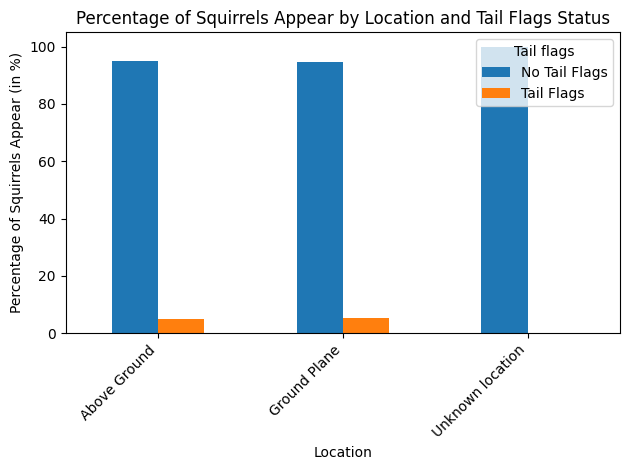

In [10]:
#Add a Total column to sum the values for corresponding locations
tail_flags_by_location['Total'] = tail_flags_by_location['No Tail Flags']+ tail_flags_by_location['Tail Flags']
print(tail_flags_by_location)
print("\n")

#Find percentage of the corresponding status
tail_flags_by_location_percentage = tail_flags_by_location.div(tail_flags_by_location['Total']/100, axis=0)
print(tail_flags_by_location_percentage)

#Bar plot with depending variable in percentage to avoid misinterpretation as number of samples from 'Groud Plane' is much higher than those who were recorded 'Above Ground'.
tail_flags_by_location_percentage[['No Tail Flags', 'Tail Flags']].plot(kind='bar', ax=plt.gca())
plt.title('Percentage of Squirrels Appear by Location and Tail Flags Status')
plt.xlabel('Location')
plt.ylabel('Percentage of Squirrels Appear (in %)')
plt.xticks(rotation = 45, ha='right')
plt.tight_layout()
plt.show()

No significant result is found. OOPS!



---

# **New Research Question Starts From Here!**

**What are the most common squirrels' behaviors ('Running', 'Chasing','Eating', 'Foraging') observed in different locations(tree vs.ground)?**

---



In [11]:
print(squirrel_location_filled_df[['Running', 'Chasing', 'Eating', 'Foraging']])

      Running  Chasing  Eating  Foraging
0       False    False   False     False
1       False    False   False     False
2       False     True   False     False
3       False    False    True      True
4       False    False   False      True
...       ...      ...     ...       ...
3018    False    False    True      True
3019    False    False   False      True
3020    False    False    True      True
3021    False    False    True     False
3022    False    False    True      True

[3023 rows x 4 columns]


                  Running  Chasing  Eating  Foraging
Location                                            
Above Ground          165      101     155       137
Ground Plane          558      174     593      1270
Unknown location        7        4      12        28


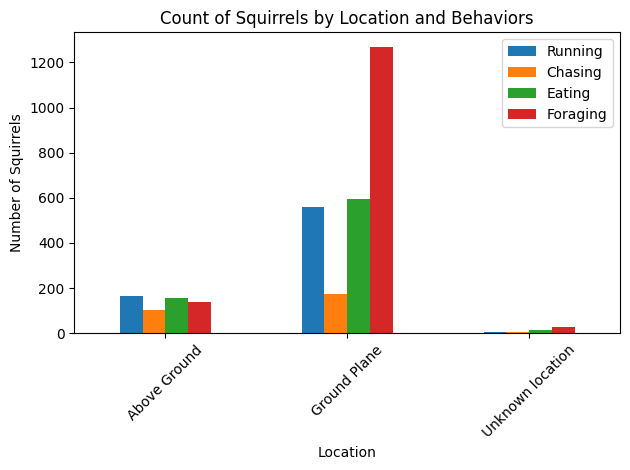

In [12]:
squirrel_location_filled_df[['Running', 'Chasing', 'Eating', 'Foraging']].fillna(False, inplace=True) #Fill any remaining NaNs

behaviors_by_location = squirrel_location_filled_df.groupby('Location')[['Running', 'Chasing', 'Eating', 'Foraging']].sum()

print(behaviors_by_location)
behaviors_by_location.plot(kind='bar', ax=plt.gca())
plt.title('Count of Squirrels by Location and Behaviors')
plt.xlabel('Location')
plt.ylabel('Number of Squirrels')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

                  Running  Chasing  Eating  Foraging  Total
Location                                                   
Above Ground          165      101     155       137    558
Ground Plane          558      174     593      1270   2595
Unknown location        7        4      12        28     51
/n
                    Running    Chasing     Eating   Foraging  Total
Location                                                           
Above Ground      29.569892  18.100358  27.777778  24.551971  100.0
Ground Plane      21.502890   6.705202  22.851638  48.940270  100.0
Unknown location  13.725490   7.843137  23.529412  54.901961  100.0
/n


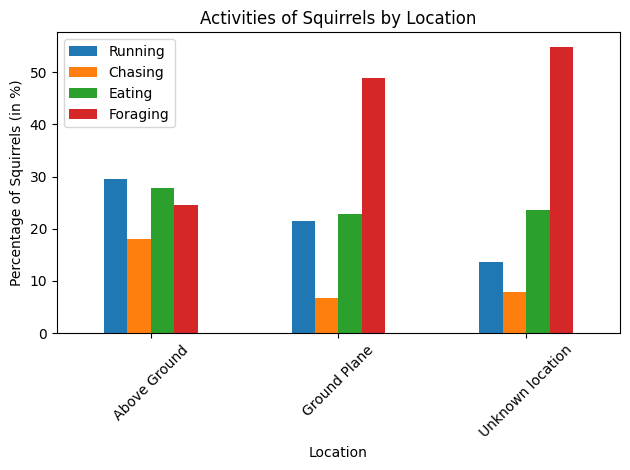

In [13]:
squirrel_location_filled_df[['Running', 'Chasing', 'Eating', 'Foraging']].fillna(False, inplace=True) #Fill any remaining NaNs

behaviors_by_location = squirrel_location_filled_df.groupby('Location')[['Running', 'Chasing', 'Eating', 'Foraging']].sum()

behaviors_by_location['Total'] = behaviors_by_location['Running']+behaviors_by_location['Chasing']+behaviors_by_location['Eating']+behaviors_by_location['Foraging']
behaviors_by_location_percentage = behaviors_by_location.div(behaviors_by_location['Total']/100, axis =0)
print(behaviors_by_location)
print("/n")
print(behaviors_by_location_percentage)
print("/n")

behaviors_by_location_percentage[['Running', 'Chasing', 'Eating', 'Foraging']].plot(kind='bar', ax=plt.gca())
plt.title('Activities of Squirrels by Location')
plt.xlabel('Location')
plt.ylabel('Percentage of Squirrels (in %)')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()


In [14]:
chi2_stat, p_val = chi2(squirrel_location_filled_df[['Running', 'Chasing', 'Eating', 'Foraging']], squirrel_location_filled_df['Location'])
print("Chi-Squared Test with Categorical Data: ")
print(f"Chi2 Stat: {chi2_stat[0]}, P-Value: {p_val[0]}\n")

if p_val[0] < 0.05:
  print("Conclusion: There is a significant association between behavior and location.")
elif p_val[0] >= 0.05:
  print("Conclusion: There is no significant association")

Chi-Squared Test with Categorical Data: 
Chi2 Stat: 16.260457966385488, P-Value: 0.00029450075736070096

Conclusion: There is a significant association between behavior and location.


In [15]:
#Map location
location_map={'Unknown location':0, 'Above Ground':1, 'Ground Plane':2,}
squirrel_location_filled_df['Location']= squirrel_location_filled_df['Location'].map(location_map)

squirrel_location_filled_df['Location'].unique()

array([0, 1, 2])

# **Selecting the top features**

Use the Chi-Squared test to evaluate the independence between each feature and the target variable, selecting the top features based on their Chi-Squared scores

In [16]:
# Apply fit_transform individually with Foraging
le = LabelEncoder()
squirrel_location_filled_df['location_encoded']=le.fit_transform(squirrel_location_filled_df['Location'])
squirrel_location_filled_df['foraging_encoded']=le.fit_transform(squirrel_location_filled_df['Foraging'])

chi2_stat, p_val = chi2(squirrel_location_filled_df[['foraging_encoded']], squirrel_location_filled_df['location_encoded'])
print("Chi-Squared Test with Categorical Data: ")
print(f"Chi2 Stat: {chi2_stat[0]}, P-Value: {p_val[0]}\n")

if p_val[0] < 0.05:
  print("Conclusion: There is a significant association between behavior and location.")
elif p_val[0] >= 0.05:
  print("Conclusion: There is no significant association")

Chi-Squared Test with Categorical Data: 
Chi2 Stat: 243.45935687196214, P-Value: 1.359791654379747e-53

Conclusion: There is a significant association between behavior and location.


In [17]:
#Calling Label Encoder and apply fit_transform
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(squirrel_location_filled_df['Location'])

selected_features_cols = ['Running', 'Chasing', 'Eating', 'Foraging']
X_df_raw = squirrel_location_filled_df[selected_features_cols].copy()

#Dummies for X
X = pd.get_dummies(X_df_raw, columns=selected_features_cols, drop_first=True)

#chi2 feature selection
selector = SelectKBest(chi2, k=3)
X_new = selector.fit_transform(X,y)

selected_features = X.columns[selector.get_support(indices=False)]
discarded_features = X.columns[~selector.get_support()]

print("Chi-Squared Test for Feature Selection:")
print('Selected Features:', selected_features)
print('Discarded Features:', discarded_features)

feature_scores = pd.DataFrame({'Feature':X.columns, 'Chi2 Score':selector.scores_, 'P-value': selector.pvalues_})
feature_scores = feature_scores.sort_values(by ='Chi2 Score', ascending = False).reset_index(drop=True)
print(feature_scores)

Chi-Squared Test for Feature Selection:
Selected Features: Index(['Running_True', 'Eating_True', 'Foraging_True'], dtype='object')
Discarded Features: Index(['Chasing_True'], dtype='object')
         Feature  Chi2 Score       P-value
0  Foraging_True  243.459357  1.359792e-53
1    Eating_True   23.335411  8.566037e-06
2   Running_True   16.260458  2.945008e-04
3   Chasing_True    9.853164  7.251245e-03


# **ANOVA**

null: No difference in the numeric variable between the categorical variables

import statsmodels.stats.multicomp as mc #add to the top of the notebook

comp = mc.MultiComparison(df['num_var'], df['cat_var']) #make sure the numeric variable go first

result = comp.tukeyhsd() #Honestly Significant Difference

result.summary()

In [18]:
#Map location
location_map={0:'Unknown location', 1: 'Above Ground',2: 'Ground Plane',}
squirrel_location_filled_df['Location']= squirrel_location_filled_df['Location'].map(location_map)

squirrel_location_filled_df['Location'].unique()

array(['Unknown location', 'Above Ground', 'Ground Plane'], dtype=object)

In [19]:
comp = mc.MultiComparison(squirrel_location_filled_df[['Foraging']], squirrel_location_filled_df['Location']) #make sure the numeric variable go first
result = comp.tukeyhsd() #Honestly Significant Difference
result.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Above Ground,Ground Plane,0.4377,0.0,0.3938,0.4816,True
Above Ground,Unknown location,0.275,0.0,0.1352,0.4148,True
Ground Plane,Unknown location,-0.1627,0.0147,-0.2995,-0.0259,True


In [ ]:
comp = mc.MultiComparison(squirrel_location_filled_df[['Eating']], squirrel_location_filled_df['Location']) #make sure the numeric variable go first
result = comp.tukeyhsd() #Honestly Significant Difference
result.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Above Ground,Ground Plane,0.0964,0.0,0.0551,0.1376,True
Above Ground,Unknown location,0.0036,0.9977,-0.1276,0.1349,False
Ground Plane,Unknown location,-0.0927,0.208,-0.2212,0.0357,False


In [ ]:
comp = mc.MultiComparison(squirrel_location_filled_df[['Running']], squirrel_location_filled_df['Location']) #make sure the numeric variable go first
result = comp.tukeyhsd() #Honestly Significant Difference
result.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Above Ground,Ground Plane,0.068,0.0003,0.0272,0.1087,True
Above Ground,Unknown location,-0.0864,0.2629,-0.2161,0.0434,False
Ground Plane,Unknown location,-0.1543,0.0122,-0.2813,-0.0274,True


In [ ]:
comp = mc.MultiComparison(squirrel_location_filled_df[['Chasing']], squirrel_location_filled_df['Location']) #make sure the numeric variable go first
result = comp.tukeyhsd() #Honestly Significant Difference
result.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Above Ground,Ground Plane,-0.0376,0.0041,-0.0652,-0.01,True
Above Ground,Unknown location,-0.0573,0.2774,-0.1452,0.0306,False
Ground Plane,Unknown location,-0.0197,0.8526,-0.1057,0.0663,False


The ANOVA Test also suggests that there is a significant difference of squirrels' activities in foraging, eating, running, and chasing between above ground and ground plane.

# **KNN**

In [20]:
selected_features_cols = ['Running', 'Chasing', 'Eating', 'Foraging']

features = squirrel_location_filled_df[selected_features_cols]
labels = squirrel_location_filled_df['Location']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state = 42)

In [21]:
model = KNeighborsClassifier(n_neighbors=5)

#Fit the model
model.fit(X_train, y_train)

#Test the model
pred = model.predict(X_test)

In [22]:
#Evaluate model's accuracy
print(accuracy_score(y_test, pred))

0.7966942148760331


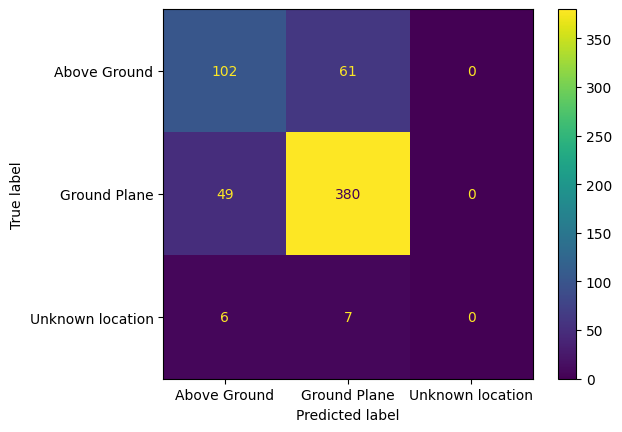

In [23]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, pred, display_labels= model.classes_)

plt.show()

The diagonal numbers are the correctly predicted for the squirrels' behaviors by location. 482 out of 605 samples were correctly predicted. The overall accuracy is 79.67%.

The accuracy score is 0.7966942148760331


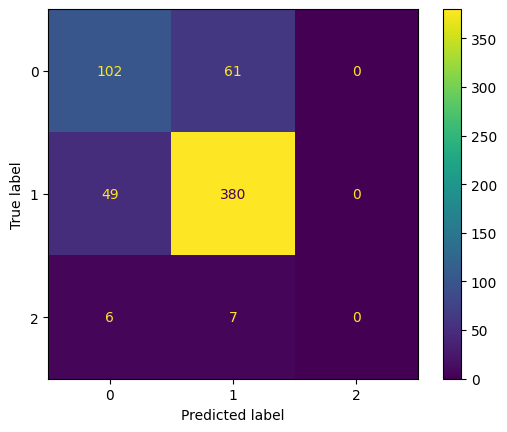

In [24]:
selected_features_cols = ['Running', 'Chasing', 'Eating', 'Foraging']

X_raw_features = squirrel_location_filled_df[selected_features_cols]
y_raw_labels = squirrel_location_filled_df['Location']

# Fit on all target labels
label_encoder = LabelEncoder()
label_encoder.fit(y_raw_labels)

# transform
y = label_encoder.transform(y_raw_labels)

#Fit on all tar
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state = 42)

model = KNeighborsClassifier(n_neighbors=5)

#Fit the model
model.fit(X_train, y_train)

#Test the model
pred = model.predict(X_test)

#Evaluate model's accuracy
print(f"The accuracy score is {accuracy_score(y_test, pred)}")

metrics.ConfusionMatrixDisplay.from_predictions(y_test, pred, display_labels= model.classes_)

plt.show()

In [25]:
#decode labels for readable output
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(pred)

In [26]:
results_df = pd.DataFrame({
    'True Label': y_test_labels,
    'Predicted Label': y_pred_labels
})

results_df['Correct'] = results_df['True Label'] == results_df['Predicted Label']
filtered_df = results_df[results_df['True Label']!='Unknown location']


#Count correct/incorrect per label
counts = results_df.groupby(['True Label', 'Correct']).size().unstack(fill_value = 0)
counts.columns = ['Incorrect', 'Correct']

filtered_counts = filtered_df.groupby(['True Label', 'Correct']).size().unstack(fill_value = 0)
filtered_counts.columns = ['Incorrect', 'Correct']

print(results_df)

print(counts)

print(filtered_counts)



       True Label Predicted Label  Correct
0    Ground Plane    Ground Plane     True
1    Ground Plane    Ground Plane     True
2    Above Ground    Ground Plane    False
3    Ground Plane    Ground Plane     True
4    Ground Plane    Ground Plane     True
..            ...             ...      ...
600  Ground Plane    Ground Plane     True
601  Above Ground    Above Ground     True
602  Ground Plane    Ground Plane     True
603  Ground Plane    Ground Plane     True
604  Ground Plane    Above Ground    False

[605 rows x 3 columns]
                  Incorrect  Correct
True Label                          
Above Ground             61      102
Ground Plane             49      380
Unknown location         13        0
              Incorrect  Correct
True Label                      
Above Ground         61      102
Ground Plane         49      380


In [27]:
counts['Total'] = counts['Incorrect'] + counts['Correct']

print(counts)

TF_percent = counts.div(counts['Total']/100, axis =0)

print(TF_percent)

filtered_counts['Total'] = filtered_counts['Incorrect'] + filtered_counts['Correct']
TF_filtered_percent = filtered_counts.div(filtered_counts['Total']/100, axis =0)

print(TF_filtered_percent)

                  Incorrect  Correct  Total
True Label                                 
Above Ground             61      102    163
Ground Plane             49      380    429
Unknown location         13        0     13
                   Incorrect    Correct  Total
True Label                                    
Above Ground       37.423313  62.576687  100.0
Ground Plane       11.421911  88.578089  100.0
Unknown location  100.000000   0.000000  100.0
              Incorrect    Correct  Total
True Label                               
Above Ground  37.423313  62.576687  100.0
Ground Plane  11.421911  88.578089  100.0


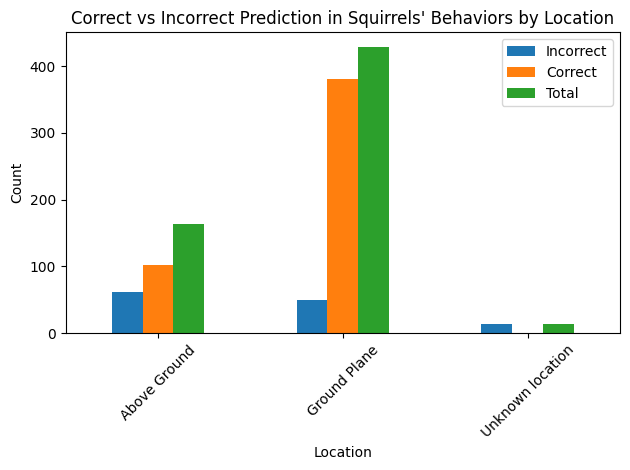

In [28]:
#Bar plot

counts.plot(kind = 'bar')
plt.title("Correct vs Incorrect Prediction in Squirrels' Behaviors by Location")
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

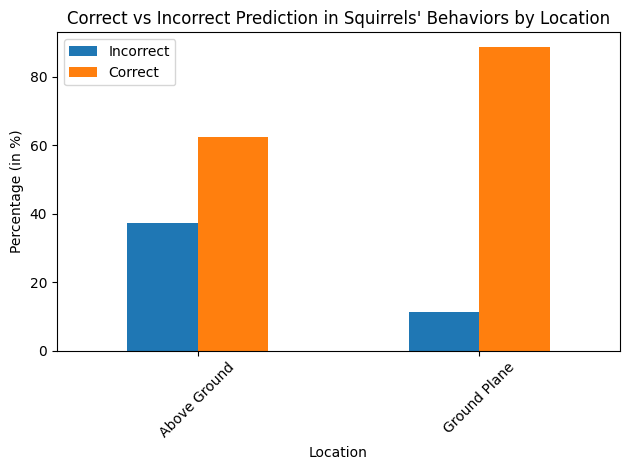

In [29]:
#Bar plot
TF_filtered_percent[['Incorrect', 'Correct']].plot(kind = 'bar')
plt.title("Correct vs Incorrect Prediction in Squirrels' Behaviors by Location")
plt.xlabel('Location')
plt.ylabel('Percentage (in %)')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()